<h1><center>SpaGCN Tutorial</center></h1>


<center>Author: Jian Hu,*, Xiangjie Li, Kyle Coleman, Amelia Schroeder, Nan Ma, David J. Irwin, Edward B. Lee, Russell T. Shinohara, Mingyao Li*

### Outline
1. Installation
2. Import modules
3. Read in data
4. Integrate gene expression and histology into a Graph
5. Spatial domain detection using SpaGCN
6. Identify SVGs
7. Identify Meta Gene
8. Multiple tissue sections analysis

### 1. Installation
To install SpaGCN package you must make sure that your python version is over 3.5.=. If you don’t know the version of python you can check it by:

In [1]:
import platform
platform.python_version()

'3.8.8'

### 2. Import python modules

In [2]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2

/home/sergio/anaconda3/lib/python3.8/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((llvmlite 0.38.1 (/home/sergio/.local/lib/python3.8/site-packages), Requirement.parse('llvmlite<0.37,>=0.36.0rc1'), {'numba'}))'.
  numba.core.entrypoints.init_all()


In [3]:
spg.__version__

'1.2.5'

### 3. Read in data
The current version of SpaGCN requres three input data: 
<br>
1. The gene expression matrix(n by k): expression_matrix.h5;
<br>
2. Spatial coordinateds of samplespositions.txt;
<br>
3. Histology image(optional): histology.tif, can be tif or png or jepg.
<br>
The gene expreesion data can be stored as an AnnData object. AnnData stores a data matrix .X together with annotations of observations .obs, variables .var and unstructured annotations .uns. 

In [4]:
"""
#Read original 10x_h5 data and save it to h5ad
from scanpy import read_10x_h5
adata = read_10x_h5("../tutorial/data/151673/expression_matrix.h5")
spatial=pd.read_csv("../tutorial/data/151673/positions.txt",sep=",",header=None,na_filter=False,index_col=0) 
adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
#Select captured samples
adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
adata.write_h5ad("../tutorial/data/151673/sample_data.h5ad")
"""
saving_path=r'../../data/processed_adata/'
adata=sc.read(saving_path+'/adata_msbrain_3rep_withclusters_only_nuclei_deep_annotation_with_colors.h5ad')
#adata=adata.layers['raw']
adata.X=adata.layers['raw']
adata=adata[adata.obs['replicate']=='1']
#Read in hitology image
img=cv2.imread("../../data/original_data/xenium_prerelease_jun20_mBrain_replicates_updated/mBrain_ff_rep1/background.tiff")

In [5]:
#import random
#some=random.sample(range(0,adata.shape[0]),1000)
#adata=adata[some,:]

### 4. Integrate gene expression and histology into a Graph

In [5]:
adata.obs['x_pixel']=adata.obs['X']
adata.obs['y_pixel']=adata.obs['Y']
adata.obs['x_array']=adata.obs['X']
adata.obs['y_array']=adata.obs['Y']

In [6]:
#Set coordinates
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

#cv2.imwrite('../../sample_results/151673_map.jpg', img_new)

- The ‘s’ parameter determines the weight given to histology when calculating Euclidean distance between every two spots. ‘s = 1’ means that the histology pixel intensity value has the same scale variance as the (x,y) coordinates, whereas higher value of ‘s’ indicates higher scale variance, hence, higher weight to histology, when calculating the Euclidean distance. 

- The "b"parameter determines the area of each spot when extracting color intensity.

In [7]:
#Calculate adjacent matrix
s=0
b=49
#adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
#If histlogy image is not available, SpaGCN can calculate the adjacent matrix using the fnction below
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)
#np.savetxt('./data/151673/adj.csv', adj, delimiter=',')

Calculateing adj matrix using xy only...


### 5. Spatial domain detection using SpaGCN

#### 5.1 Expression data preprocessing

In [8]:
#adata=sc.read("./data/151673/sample_data.h5ad")
#adj=np.loadtxt('./data/151673/adj.csv', delimiter=',')
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

#### 5.2 Set hyper-parameters

- p: Percentage of total expression contributed by neighborhoods.
- l: Parameter to control p.

In [10]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 612.8775498883018]
Run 2: l [0.01, 500.005], p [0.0, 174.35125732421875]
Run 3: l [0.01, 250.0075], p [0.0, 50.1540412902832]
Run 4: l [0.01, 125.00874999999999], p [0.0, 14.167675971984863]
Run 5: l [0.01, 62.509375], p [0.0, 3.4619836807250977]
Run 6: l [0.01, 31.2596875], p [0.0, 0.5718741416931152]
Run 7: l [15.63484375, 31.2596875], p [0.04884004592895508, 0.5718741416931152]
Run 8: l [23.447265625, 31.2596875], p [0.22742176055908203, 0.5718741416931152]
Run 9: l [27.3534765625, 31.2596875], p [0.37817275524139404, 0.5718741416931152]
Run 10: l [29.30658203125, 31.2596875], p [0.46966445446014404, 0.5718741416931152]
Run 11: l [29.30658203125, 30.283134765625], p [0.46966445446014404, 0.5194358825683594]
recommended l =  29.794858398437498


In [9]:
p=0.5

In [10]:
l=29.7

- n_clusters: Number of spatial domains wanted.
- res: Resolution in the initial Louvain's Clustering methods. If the number of clusters is known, we can use the spg.search_res() fnction to search for suitable resolution(optional)

In [11]:
#If the number of clusters known, we can use the spg.search_res() fnction to search for suitable resolution(optional)
#For this toy data, we set the number of clusters=7 since this tissue has 7 layers
n_clusters=36
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  20
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  20
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  22
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  22
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
delta_label  0.003930725822144386 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 19
Res =  1.0999999999999999 Num of clusters =  23
Res changed to 1.0999999999999999
Initializing cluster centers with louv

#### 5.3 Run SpaGCN

In [12]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
#shape="hexagon" for Visium data, "square" for ST data.
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
#adata.write_h5ad("./sample_results/results.h5ad")

Initializing cluster centers with louvain, resolution =  1.9000000000000006
Epoch  0
Epoch  10
Epoch  20
delta_label  0.004786923525977817 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 28
Calculateing adj matrix using xy only...


In [13]:
adata

AnnData object with n_obs × n_vars = 25695 × 284
    obs: 'ind', 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'graph_clusters', 'kmeans2_clusters', 'kmeans3_clusters', 'kmeans4_clusters', 'kmeans5_clusters', 'kmeans6_clusters', 'kmeans7_clusters', 'kmeans8_clusters', 'kmeans9_clusters', 'kmeans10_clusters', 'replicate', 'n_counts', 'leiden_2_2', 'leiden_1_8', 'leiden_1_4', 'leiden_1_0', 'leiden_0_8', 'leiden_0_6', 'cell_code', 'expanded_class', 'expanded_initial_annotation', 'Class', 'initial_annotation', 'celltype_annotation', 'X', 'Y', 'leiden_0_4', 'leiden_0_2', 'Class_old', 'class_number', 'x_pixel', 'y_pixel', 'x_array', 'y_array', 'pred', 'refined_pred'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Class_colors', 'celltype_annotation_colors', 'dendrogram_celltype_annotation', 'dendrogram_initial_annotation', 'expanded_class_colors', 'ex

#### 5.4 Plot spatial domains

IndexError: list index out of range

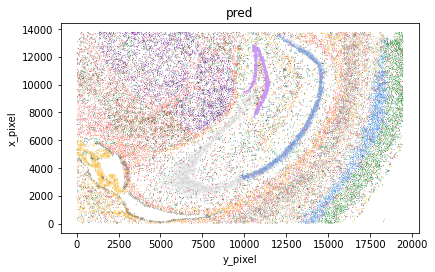

In [14]:
#adata=sc.read("./sample_results/results.h5ad")
#Set colors used
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
#plt.savefig("./sample_results/pred.png", dpi=600)
plt.close()

#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
#plt.savefig("./sample_results/refined_pred.png", dpi=600)
#plt.close()
adata.obs['spagcn_domains']=adata.obs['refined_pred']

In [16]:
adata.write('../../data/processed_adata/msbrain_spagcn_rep1.h5')

# From this part we start looking at SVG between domains

**Spatial Domains**![](./sample_results/pred.png) **Refined Spatial Domains**![](./sample_results/refined_pred.png)

### 6. Identify SVGs

In [27]:
saving_path=r'../../data/processed_adata/'
raw=sc.read(saving_path+'/adata_msbrain_3rep_withclusters.h5ad')
raw=raw.layers['raw']
raw=raw[raw.obs['replicate']=='1']

In [28]:
#Read in raw data
#raw=sc.read("../tutorial/data/151673/sample_data.h5ad")
raw.var_names_make_unique()
raw.obs["pred"]=adata.obs["pred"].astype('category')
raw.obs['x_pixel']=raw.obs['X']
raw.obs['y_pixel']=raw.obs['Y']
raw.obs['x_array']=raw.obs['X']
raw.obs['y_array']=raw.obs['Y']
#Convert sparse matrix to non-sparse
raw.X=(raw.X.A if issparse(raw.X) else raw.X)
raw.raw=raw
sc.pp.log1p(raw)

- target: Target domain to identify SVGs.
- min_in_group_fraction: Minium in-group expression fraction.
- min_in_out_group_ratio: Miniumn (in-group expression fraction) / (out-group expression fraction).
- min_fold_change: Miniumn (in-group expression) / (out-group expression).
- r: Radius to detect a spot's neighboring spots.

In [42]:
adj_2d.shape

(26354, 26354)

In [53]:
np.sum(adj_2d<120,axis=1)

array([12, 14, 12, ...,  5,  3,  6])

In [51]:
#Use domain 0 as an example
target=0
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.00001), np.quantile(adj_2d[adj_2d!=0],q=0.2)
r=spg.search_radius(target_cluster=target, cell_id=adata.obs.index.tolist(), x=x_array, y=y_array, pred=adata.obs["pred"].tolist(), start=start, end=end, num_min=10, num_max=14,  max_run=100)
#Detect neighboring domains

181.0865528156507

In [60]:
r=400 # should be defined automatically

In [61]:
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id=raw.obs.index.tolist(), 
                                   x=raw.obs["x_array"].tolist(), 
                                   y=raw.obs["y_array"].tolist(), 
                                   pred=raw.obs["pred"].tolist(),
                                   radius=r,
                                   ratio=1/2)

radius= 400 average number of neighbors for each spot is 54.64696415508413
 Cluster 0 has neighbors:
Dmain  1 :  14244
Dmain  5 :  1395
Dmain  6 :  611


In [62]:
nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=nbr_domians, 
                                label_col="pred", 
                                adj_nbr=True, 
                                log=True)
#Filter genes
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                            (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                            (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                            (filtered_info["fold_change"]>min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info["target_dmain"]=target
filtered_info["neighbors"]=str(nbr_domians)
print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())

SVGs for domain  0 : ['Slc17a7', 'Nrn1', 'Garnl3', 'Tubb2a', '2010300C02Rik', 'Dkk3', 'Ipcef1', 'Arc', 'Id2', 'Epha4', 'Satb2']


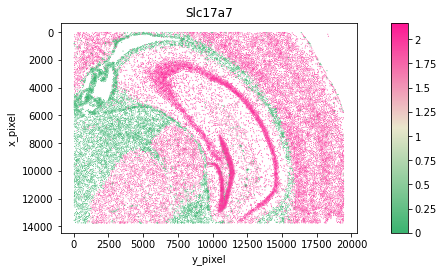

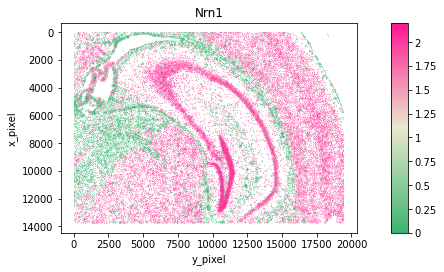

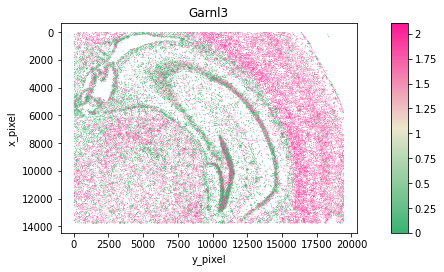

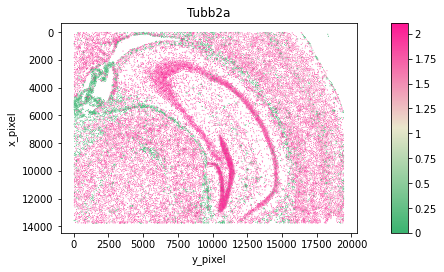

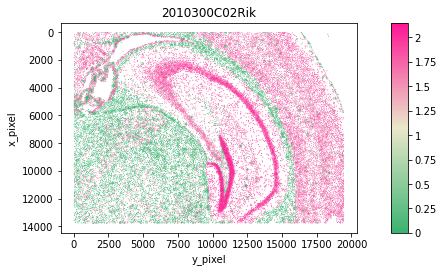

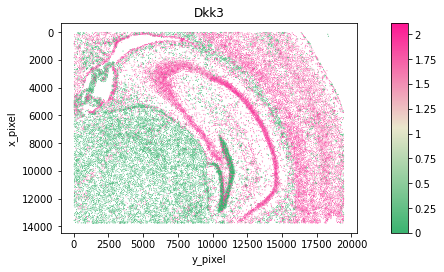

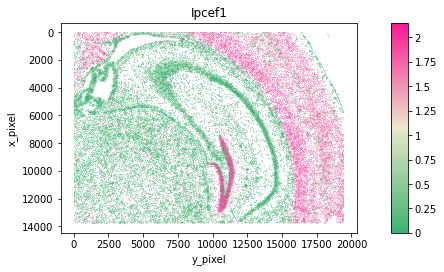

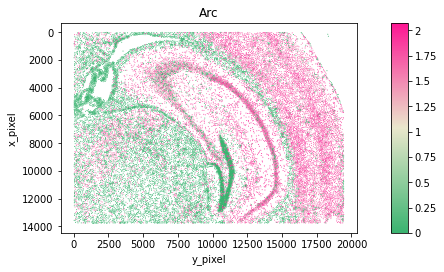

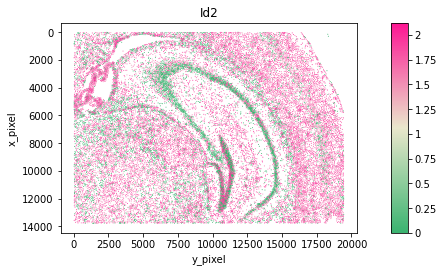

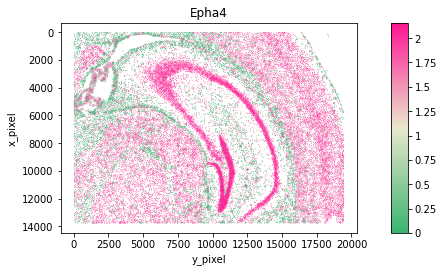

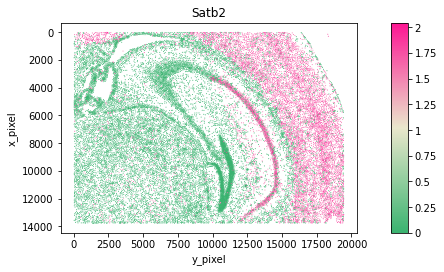

In [64]:
#Plot refinedspatial domains
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
for g in filtered_info["genes"].tolist():
    raw.obs["exp"]=raw.X[:,raw.var.index==g]
    ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=g,color_map=color_self,show=False,size=100000/raw.shape[0])
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
    #plt.savefig("./sample_results/"+g+".png", dpi=600)
    #plt.close()


**CAMK2N1**![](./sample_results/CAMK2N1.png) **ENC1**![](./sample_results/ENC1.png) **GPM6A**![](./sample_results/GPM6A.png) **ARPP19**![](./sample_results/ARPP19.png) **HPCAL1**![](./sample_results/HPCAL1.png)

### 7. Identify Meta Gene

In [132]:
#Use domain 2 as an example
target=2
meta_name, meta_exp=spg.find_meta_gene(input_adata=raw,
                    pred=raw.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="GFAP",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=3,
                    use_raw=False)

raw.obs["meta"]=meta_exp

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Add gene:  MGP
Minus gene:  FTH1
Absolute mean change: 0.8913243
Number of non-target spots reduced to: 1888
Meta gene is:  GFAP+MGP-FTH1


Trying to set attribute `.obs` of view, copying.


Add gene:  MYL9
Minus gene:  MBP
Absolute mean change: 2.175557
Number of non-target spots reduced to: 563
Meta gene is:  GFAP+MGP-FTH1+MYL9-MBP
Add gene:  KRT8
Minus gene:  MT-ATP6
Absolute mean change: 2.8935516
Number of non-target spots reduced to: 111
Meta gene is:  GFAP+MGP-FTH1+MYL9-MBP+KRT8-MT-ATP6


In [133]:
#Plot meta gene
g="GFAP"
raw.obs["exp"]=raw.X[:,raw.var.index==g]
ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=g,color_map=color_self,show=False,size=100000/raw.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./sample_results/"+g+".png", dpi=600)
plt.close()

raw.obs["exp"]=raw.obs["meta"]
ax=sc.pl.scatter(raw,alpha=1,x="y_pixel",y="x_pixel",color="exp",title=meta_name,color_map=color_self,show=False,size=100000/raw.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./sample_results/meta_gene.png", dpi=600)
plt.close()


**start**![](./sample_results/GFAP.png) **meta gene**![](./sample_results/meta_gene.png)

### 8. Multiple tissue sections analysis
In this section, we show an example on how to analysis multiple adjacent tissue sections using SpaGCN.

**Mouse brain anterior**![](./sample_results/MA1_lowres.png) **Mouse brain posterior**![](./sample_results/MP1_lowres.png)

#### 8.1 Read in data

In [30]:
adata1=sc.read("./data/Mouse_brain/MA1.h5ad")
adata2=sc.read("./data/Mouse_brain/MP1.h5ad")
img1=cv2.imread("./data/Mouse_brain/MA1_histology.tif")
img2=cv2.imread("./data/Mouse_brain/MP1_histology.tif")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#### 8.2 Extract color intensity

In [31]:
b=49
s=1
x_pixel1=adata1.obs["x4"].tolist()
y_pixel1=adata1.obs["x5"].tolist()
adata1.obs["color"]=spg.extract_color(x_pixel=x_pixel1, y_pixel=y_pixel1, image=img1, beta=b)
z_scale=np.max([np.std(x_pixel1), np.std(y_pixel1)])*s
adata1.obs["z"]=(adata1.obs["color"]-np.mean(adata1.obs["color"]))/np.std(adata1.obs["color"])*z_scale

x_pixel2=adata2.obs["x4"].tolist()
y_pixel2=adata2.obs["x5"].tolist()
adata2.obs["color"]=spg.extract_color(x_pixel=x_pixel2, y_pixel=y_pixel2, image=img2, beta=b)
z_scale=np.max([np.std(x_pixel2), np.std(y_pixel2)])*s
adata2.obs["z"]=(adata2.obs["color"]-np.mean(adata2.obs["color"]))/np.std(adata2.obs["color"])*z_scale
del img1, img2

#### 8.3 Modify coordinates to combine 2 sections

In [32]:
from anndata import AnnData
adata1.obs["x_pixel"]=x_pixel1
adata1.obs["y_pixel"]=y_pixel1
adata2.obs["x_pixel"]=x_pixel2-np.min(x_pixel2)+np.min(x_pixel1)
adata2.obs["y_pixel"]=y_pixel2-np.min(y_pixel2)+np.max(y_pixel1)
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata_all=AnnData.concatenate(adata1, adata2,join='inner',batch_key="dataset_batch",batch_categories=["0","1"])

#### 8.4 Integrate gene expression and histology into a Graph

In [34]:
X=np.array([adata_all.obs["x_pixel"], adata_all.obs["y_pixel"], adata_all.obs["z"]]).T.astype(np.float32)
adj=spg.pairwise_distance(X)

#### 8.5 Spatial domain detection using SpaGCN

In [37]:
sc.pp.normalize_per_cell(adata_all, min_counts=0)
sc.pp.log1p(adata_all)
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 144.17116893743565]
Run 2: l [0.01, 500.005], p [0.0, 24.78992462158203]
Run 3: l [0.01, 250.0075], p [0.0, 3.649960994720459]
Run 4: l [125.00874999999999, 250.0075], p [0.4487175941467285, 3.649960994720459]
Run 5: l [125.00874999999999, 187.508125], p [0.4487175941467285, 1.5741894245147705]
Run 6: l [125.00874999999999, 156.2584375], p [0.4487175941467285, 0.9070142507553101]
Run 7: l [125.00874999999999, 140.63359375], p [0.4487175941467285, 0.6537595987319946]
Run 8: l [125.00874999999999, 132.821171875], p [0.4487175941467285, 0.5454769134521484]
recommended l =  128.91496093749998


In [43]:
res=1.0
seed=100
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
clf=spg.SpaGCN()
clf.set_l(l)
clf.train(adata_all,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata_all.obs["pred"]= y_pred
adata_all.obs["pred"]=adata_all.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  1.0
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.004794180856339891 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 37


In [44]:
colors_use=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#bec1d4', '#bb7784', '#0000ff', '#111010', '#FFFF00',   '#1f77b4', '#800080', '#959595', 
 '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784', '#8e063b', '#4a6fe3', '#8595e1', '#b5bbe3', '#e6afb9', '#e07b91', '#d33f6a', '#11c638', '#8dd593', '#c6dec7', '#ead3c6', '#f0b98d', '#ef9708', '#0fcfc0', '#9cded6', '#d5eae7', '#f3e1eb', '#f6c4e1', '#f79cd4']
num_celltype=len(adata_all.obs["pred"].unique())
adata_all.uns["pred_colors"]=list(colors_use[:num_celltype])
ax=sc.pl.scatter(adata_all,alpha=1,x="y_pixel",y="x_pixel",color="pred",show=False,size=150000/adata_all.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
plt.savefig("./sample_results/mouse_barin_muti_sections_domains.png", dpi=600)
plt.close()

**SpaGCN mouse brain combines**![](./sample_results/mouse_barin_muti_sections_domains.png)